##Roger Ebert -> RoBert

a.k.a. Your Model Sucks

We'll start with the tokenized, padded data from part 0

In [14]:
from pickleshare import PickleShareDB
import os
import gc
import numpy as np
from tensorflow.keras.backend import clear_session
from tensorflow.keras import layers 
from tensorflow.keras import Input, Model
from tensorflow.keras.optimizers import Nadam
import matplotlib.pyplot as plt

In [15]:
# start by unpickling and looking at data
db=PickleShareDB(os.path.join(os.getcwd(), 'assign4.pshare'))
print(db.keys())

XTrain=db['XTrain']
XVal=db['XVal']
XTest=db['XTest']
wordIndx = db['wordIndx'] # word -> number
inv_Indx = {number: word for word, number in wordIndx.items()} # flip the script: number <- word
print(XTrain.shape) # make sure they're all there
print(XVal.shape)
print(XTest.shape)

# look at an example review
review = XTrain[0]
print(XTrain[0]) # numbers
print(' '.join([inv_Indx[wordCode] for wordCode in XTrain[0]]).replace(' br br ', '. ')) # comprehension

['XTestEm', 'emMat10000X100', 'XValEm', 'yVal', 'wordIndx', 'XVal', 'yTest', 'XTrain', 'XTrainEm', 'yTrain', 'XTest']
(2000, 80)
(6000, 80)
(6000, 80)
[1211   17    2   12    9   13   90    8 2317    7    7  551    1 3172
    6 1015  592    7    7   91    3  592   17    2    1  428    2 6580
  486    6   52 1917    7    7  589   89  435  332   55 2644    2  146
   11   17   91  481  592    7    7   10 2794  248    4    1  252   79
  570   14   10 6303   20  126 2625   91   28    4    1  115 1211   99
  123  806   43   11 4303 5772 5574  895 2359  422]
cult movie and that it was made in germany. anyway the nose is fairly crap. its a crap movie and the picture and volume quality is very rubbish. please don't waste you're time buying and watching this movie its totally crap. i prefer day of the woman also known as i spit on your grave its one of the best cult movies ever check out this link http www imdb com title


Looks like the data are all there. The first review doesn't look very promising.

In [16]:
# hyperparameters - max len and maxwords are fixed from part 0
maxLen=80
maxWords=10000
batch_size=32
emDim=64

In [17]:
# take out the garbage
clear_session()
gc.collect()

4340

Now we'll define an autoencoder - an encoder and decoder. The goal is to produce an accurate representation of the review. The first step is embedding the words. This converts the numbers, which link back to words via the index, into feature-space. This feel kind of like the filters in CNN rating each little patch on how similar it is to a vertical line, small circle, etc. Here, I suppose the embedder is rating each word on it's 'verb-ness' or 'past-tenseness'

In [18]:
inputPadded=layers.Input(shape=(maxLen,)) # input layer, 80 words
# embedding layer -> puts words into feature-space
embedLayer=layers.Embedding( 
    maxWords, # number of possible words -> We'll train an embedding for each
    output_dim=emDim, # categories to embed into
    input_length=maxLen) # size of review put in

# bulding the encoder using the API. Allows us to stack 2 models
x = embedLayer(inputPadded)
# LSTM layers - looks at each word and uses it's memory of the overall encoding
# bidirectional means it can see words before and after the word in question
# unidirectional or causal would be for time series etc.
state_hidden=layers.Bidirectional(layers.LSTM(64,activation='selu'))(x)

encodeM=Model(inputs=inputPadded,outputs=state_hidden, name = 'encoder') # declare a model

encoderOut=encodeM(inputPadded) # this hidden output is the product of the model

Now we'll design the decoder. This will take the hidden output from the LSTM layer and convert it back into words.
The RepeatVector layer helps us deal with the problem that we put a sequence of 80 words in, converted to an embeded meaning, and then we want to get a sequence of words out.

In [19]:
decoded=layers.RepeatVector(maxLen)(encoderOut) # spawns 1 copy of the encoding per word
dec_lstm=layers.Bidirectional(layers.LSTM(64, # another LSTM with bidirectional inputs
        return_sequences=True)) # return sequences means it will give 1 word output for each copy of the encoding
decoded_lstm_output=dec_lstm(decoded) # lstm works on repeated code
dec_dense=layers.Dense(maxWords,activation='softmax') # dense output layer, gives probabilites of each word
decoder_outputs=dec_dense(decoded_lstm_output)

autoEnc_Model=Model(inputPadded,decoder_outputs, name='AutoEncoder') # put the 2 halves of the model together
autoEnc_Model.summary()

Model: "AutoEncoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80)]              0         
_________________________________________________________________
encoder (Model)              (None, 128)               706048    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 80, 128)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 80, 128)           98816     
_________________________________________________________________
dense (Dense)                (None, 80, 10000)         1290000   
Total params: 2,094,864
Trainable params: 2,094,864
Non-trainable params: 0
_________________________________________________________________


In [20]:
autoEnc_Model.compile(optimizer=Nadam(lr=1e-3), # compile model, Nesterov mod of adam optimizer
                      loss='sparse_categorical_crossentropy' # because our data is 2,3 not [[0,1,0],[0,0,1]
                     )

In [21]:
# early stopping is are regularization technique to stop training when the 
# validation accuracy stops changing. This stops the model before it overfits (regularization)
# it also makes training faster. Another option would be to change the error rate
# note this is a version of 'peeking' at the validation data, hence why we need a test set
from tensorflow.keras.callbacks import EarlyStopping
callback=EarlyStopping(monitor='val_loss',patience=3)

In [22]:
# train the model
history=autoEnc_Model.fit(XTrain,
                          np.expand_dims(XTrain,-1), #target is self, reshaped for cross entropy
                         batch_size=batch_size,
                         epochs=30,
                         validation_data=(XVal,XVal), # validation target is self
                         verbose=1, # I don't want to watch the bars go by
                         callbacks=[callback])

Epoch 1/30
63/63 [==============================] - 29s 454ms/step - loss: 7.1513 - val_loss: 6.5242
Epoch 2/30
63/63 [==============================] - 28s 437ms/step - loss: 6.5305 - val_loss: 6.5339
Epoch 3/30
63/63 [==============================] - 28s 439ms/step - loss: 6.5257 - val_loss: 6.5378
Epoch 4/30
63/63 [==============================] - 28s 439ms/step - loss: 6.5192 - val_loss: 6.5316


In [23]:
# we'll save the encoder weights to use in part 2
encodeM.save_weights('assign-4-encoder.h5')

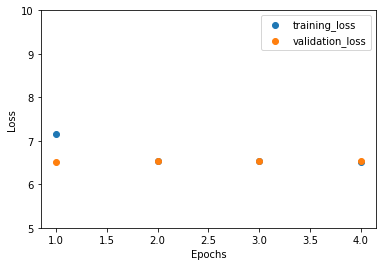

In [24]:
# plot loss over time
val_loss = history.history['val_loss']
loss = history.history['loss']
epochs = range(1, len(loss) + 1)
labels = []
fig, ax = plt.subplots()
ax.scatter(epochs, loss)
labels.append('training_loss')
ax.scatter(epochs, val_loss)
labels.append('validation_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
ax.set_ylim(5, 10)
plt.legend(labels=labels)

In [25]:
plt.close()

Is that a good loss? No idea. Let's see if it works.

In [26]:
sample = XVal[21:53] # batch of reviews

# goal review
print(' '.join([inv_Indx[wordCode] for wordCode in sample[0]]).replace(' br br ', '. ')) # excellent
auto_sample = autoEnc_Model([sample])[0] # first review
auto_sample_max = np.argmax(auto_sample, axis = 1)
print(' '.join([inv_Indx[wordCode] for wordCode in auto_sample_max]).replace(' br br ', '. ')) # 'dreck' -> 'the' :(


insult as far as i was concerned because there were so many this movie could of explored and went down but it chose to take the cliché ridden one the 2 stars are for 2 of the stars the little girl who i thought was very good and lindsey price who character was annoying but she did what she could with it my advice is take a vice and squeeze your head with it instead of looking at this dreck
the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the


In [27]:
#let's use random choice
guesses = []
for probs in auto_sample:
    probsB = probs.numpy() / np.sum(probs.numpy()) # rescale - doesn't quite sum to 1 tf<->numpy problem?
    guess = np.random.choice(a=range(1,maxWords+1), p=probsB) # randomly pick word index, weights based on autoencoder
    guess = inv_Indx[guess] # convert to word
    guesses.append(guess)
newguess = ' '.join(guesses).replace(' br ', '. ').replace('. . ', '. ')
print(newguess) # slightly better than gibberish

lead because doesn't 1948 sf plot is wonderful of constantly and it is that rings his on does is devil stand worse unfortunately to is growth up then before for main to movie a an you a make all odds another keeps is darren than the here other actors to in that or. he a looking of and time no the and knew person really early were making this more thing their with. day of fan was came


In [28]:
XTrainEm=encodeM.predict(XTrain)
XValEm=encodeM.predict(XVal)
XTestEm=encodeM.predict(XTest)
XTestEm.shape

(6000, 128)

In [29]:
db['XTrainEm'] = XTrainEm
db['XValEm'] = XValEm
db['XTestEm'] = XTestEm